In [3]:
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

from sklearn.cluster import KMeans, DBSCAN, SpectralClustering

from sklearn.metrics import adjusted_rand_score

<h2> Generation </h2>

In [4]:
def generate_clusters(params):
    
    # generate data
    X = []
    for i in range(len(params['means'])):
        X.append(
            np.random.multivariate_normal(
                mean = params['means'][i], 
                cov = params['covs'][i], 
                size = params['sizes'][i]
            )
        )
    X = np.concatenate(
        tuple(
            ( X[i] for i in range(len(X)) )
        )
    )  
    
    # generate labels$
    idx = []
    for i in range(len(params['means'])):
        idx.extend(
            [i]*params['sizes'][i]
        )
    idx = np.array(idx).astype(int)
    
    # name the columns
    col_name = []
    for i in range(len(params['means'][0])):
        col_name.append("X{}".format(i))
    col_name.append('Group')
    
    # data is the concat
    data = pd.DataFrame(
        data = np.c_[X, idx],
        columns = col_name
    )
    
    return data

In [20]:
cov = np.diag(0.7*np.ones(2))
params = {
    'means': [[1, 1], [-1, -1], [0, 0], [2, -2]],
    'covs': [0.1*cov, 0.1*cov, 0.1*cov, 0.1*cov],
    'sizes': [55, 45, 60, 60]
}

data = generate_clusters(params)

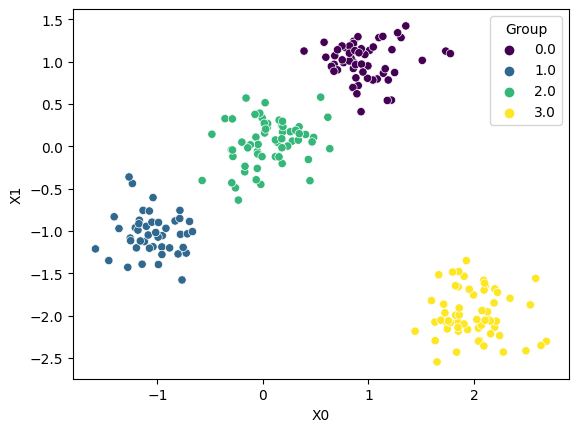

In [21]:
plt.figure()

sns.scatterplot(
    data = data, 
    x = 'X0', 
    y = 'X1', 
    hue = 'Group',
    palette = 'viridis'
)

plt.show()

<h2> Clustering method </h2>

In [7]:
Xtrain = data[['X0', 'X1']].copy()

In [8]:
K_vals = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

rand_inds = []
for k in K_vals:
    kmeans = KMeans(n_clusters = k)
    labels_pred = kmeans.fit_predict(Xtrain)
    rand_inds.append(adjusted_rand_score(data['Group'], labels_pred))

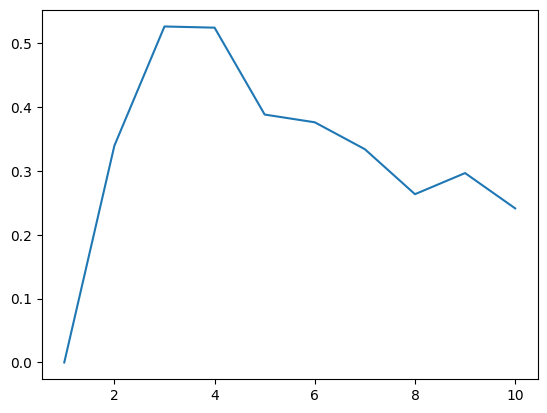

In [9]:
plt.figure()

plt.plot(K_vals, rand_inds)

<h2> Power analysis </h2>

In [36]:
def experiment(
    dimension,
    nb_samples,
    relative_proportions,
    centroids_distances,
    repet
):
    d = dimension
    results = []
    for N in tqdm(nb_samples):
        for prop in relative_proportions:
            for dist in centroids_distances:
                for r in range(repet):
                    # set parameters
                    cov = np.diag(0.7*np.ones(d))
                    size0 = int(prop*N)
                    params = {
                        'means': [[0]*d, [np.sqrt(dist/d)]*d],
                        'covs': [cov, cov],
                        'sizes': [size0, N - size0]
                    }
                    # generate data
                    data = generate_clusters(params)
                    Xtrain = data[['X0', 'X1']].copy()
                    # train several methods
                    # kmeans
                    kmeans = KMeans(n_clusters = 2)
                    labels_pred = kmeans.fit_predict(Xtrain)
                    rand_ind_kmeans = adjusted_rand_score(data['Group'], labels_pred)
                    # dbscan
                    dbscan = DBSCAN(eps=0.01)
                    labels_pred = dbscan.fit_predict(Xtrain)
                    rand_ind_dbscan = adjusted_rand_score(data['Group'], labels_pred)
                    # spectral
                    # spectral = SpectralClustering(n_clusters = 2)
                    # labels_pred = spectral.fit_predict(Xtrain)
                    # rand_ind_spectral = adjusted_rand_score(data['Group'], labels_pred)
                    # add to results
                    dict_res = {
                        'nb_samples': N,
                        'prop': prop,
                        'dist': dist,
                        'repet': r,
                        'rand_ind_kmeans': rand_ind_kmeans,
                        'rand_ind_dbscan': rand_ind_dbscan,
                        #'rand_ind_spectral': rand_ind_spectral
                    }
                    results.append(dict_res)
    results = pd.DataFrame(results)
    return results

In [56]:
results = experiment(
    dimension = 100,
    nb_samples = [50, 100, 200, 1000],
    relative_proportions = [0.1, 0.2, 0.3, 0.4, 0.5],
    centroids_distances = [1., 10., 50., 100.],
    repet = 10
)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:25<00:00,  6.36s/it]


In [57]:
results.head()

,nb_samples,prop,dist,repet,rand_ind_kmeans,rand_ind_dbscan
0,50,0.1,1.0,0,0.034673,0.0
1,50,0.1,1.0,1,0.041831,0.0
2,50,0.1,1.0,2,0.003039,0.0
3,50,0.1,1.0,3,-0.001976,0.0
4,50,0.1,1.0,4,0.156673,0.0


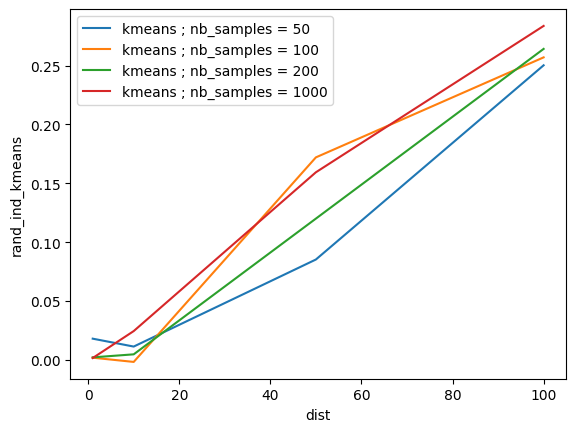

In [71]:
plt.figure()


for n in [50, 100, 200, 1000]:
    sns.lineplot(
        data = results[(results['nb_samples'] == n) & (results['prop'] == 0.3)].groupby('dist').mean() ,
        x = 'dist',
        y = 'rand_ind_kmeans',
        label = 'kmeans ; nb_samples = {}'.format(n)
    )

plt.legend(loc = 'best')
plt.show()

In [67]:
results[(results['nb_samples'] == n) & (results['prop'] == 0.5)]['rand_k_']

,nb_samples,prop,dist,repet,rand_ind_kmeans,rand_ind_dbscan
760,1000,0.5,1.0,0,-0.000805,0.0
761,1000,0.5,1.0,1,0.000937,0.0
762,1000,0.5,1.0,2,-0.000517,0.0
763,1000,0.5,1.0,3,-0.000745,0.0
764,1000,0.5,1.0,4,0.013901,0.0
765,1000,0.5,1.0,5,0.012011,0.0
766,1000,0.5,1.0,6,-0.000675,0.0
767,1000,0.5,1.0,7,0.000029,0.0
768,1000,0.5,1.0,8,0.003914,0.0
769,1000,0.5,1.0,9,-0.000517,0.0
